## Importing Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 

import os
import math
import datetime
import csv
import time
import random
import pickle
import gc
from collections import Counter
from tqdm import tqdm

import networkx as nx
import pdb

import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.sparse.linalg import svds, eigs

## Loading Data

Loading the data and removing the header line and saving it again as a CSV. Removing the header line as network-x does not support it. 

In [3]:
if not os.path.isfile('./data/train_woheader.csv'):
    data = pd.read_csv('./data/train.csv')
    data.to_csv('./data/train_woheader.csv', header=False, index=False)
else:
    g = nx.read_edgelist('./data/train_woheader.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
    print(nx.info(g))

Displaying a sub-graph

DiGraph with 66 nodes and 50 edges


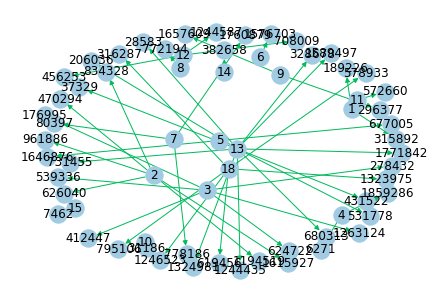

In [6]:
if not os.path.isfile('./data/train_woheader_sample.csv'):
    pd.read_csv('./data/train_woheader.csv', nrows=50).to_csv('./data/train_woheader_sample.csv', header=False, index=False)

subgraph = nx.read_edgelist('./data/train_woheader_sample.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)

pos_dict = nx.spring_layout(subgraph)
nx.draw(subgraph, pos_dict,1 node_color='#A0CBE2', edge_color='#00BB5E', width=1, edge_cmap=plt.cm.Blues, with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

##  Exploratory Data Analysis

In [8]:
g = nx.read_edgelist('./data/train_woheader.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


In [9]:
print(f"The number of unique persons/users: {len(g.nodes())}")

The number of unique persons/users: 1862220


Number of Followers for each person

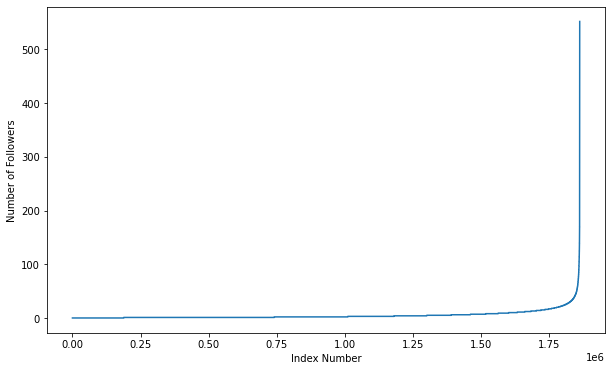

In [11]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index Number')
plt.ylabel('Number of Followers')
plt.show()

Zooming in a bit

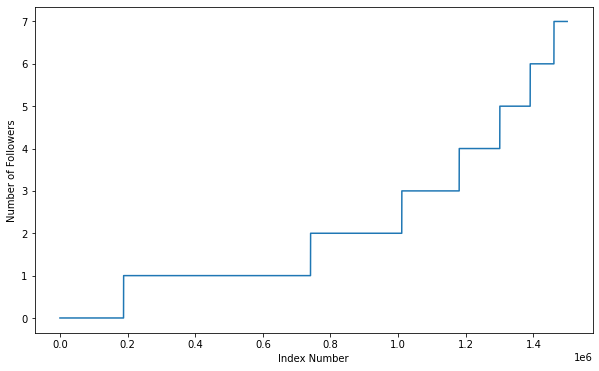

In [12]:
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[:1500000])
plt.xlabel('Index Number')
plt.ylabel('Number of Followers')
plt.show()

Box Plot of the Number of Followers

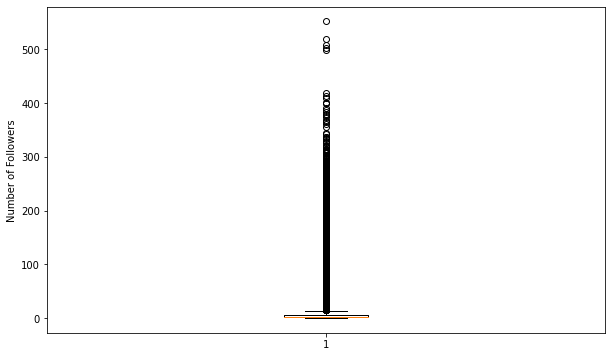

In [16]:
plt.figure(figsize=(10,6))
plt.boxplot(indegree_dist)
plt.ylabel('Number of Followers')
plt.show()

Zooming in a bit

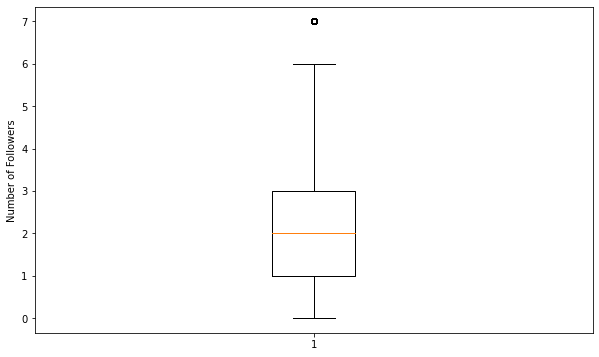

In [14]:
plt.figure(figsize=(10,6))
plt.boxplot(indegree_dist[:1500000])
plt.ylabel('Number of Followers')
plt.show()

Percentile Analysis on Number of Followers

90 - 100 Percentile

In [19]:
for i in range(0,11):
    print(f"{90+i} percentile value is {np.percentile(indegree_dist, 90+i)}")

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99 percentile of users have number of followers as 40.
On closer inspection, between 99 and 100 percentile of the users:

In [21]:
for i in range(1,11):
    print(f"{99+(i/10)} percentile value is {np.percentile(indegree_dist, 99+(i/10))}")

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


PDF of the Follower Distribution

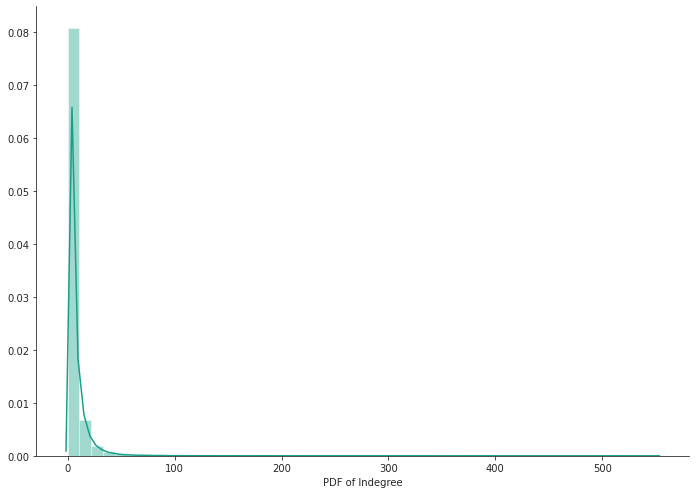

In [22]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color="#16A085")
plt.xlabel('PDF of Indegree')
sns.despine()

Number of people each person is following

Text(0, 0.5, 'Following')

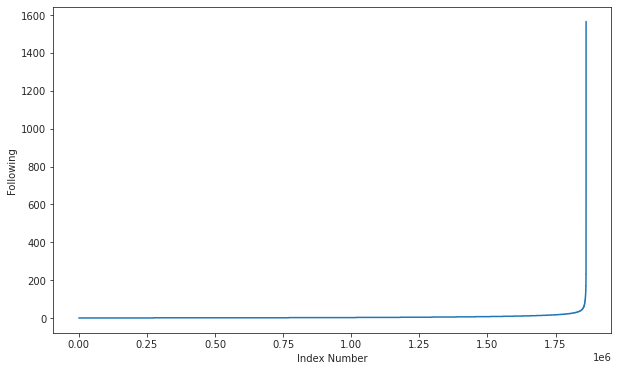

In [24]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index Number')
plt.ylabel('Following')

Zooming in a bit

Text(0, 0.5, 'Following')

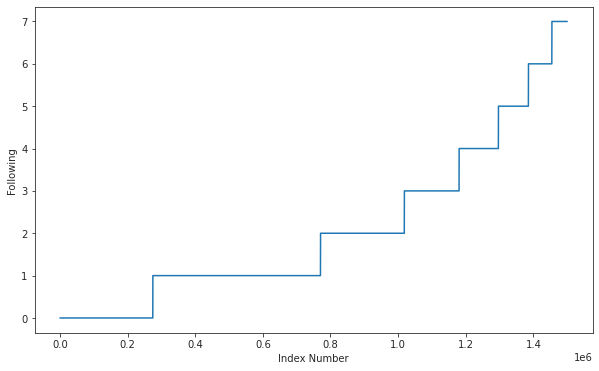

In [25]:
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[:1500000])
plt.xlabel('Index Number')
plt.ylabel('Following')

Boxplot of Number of People Following

Text(0, 0.5, 'Number of Following')

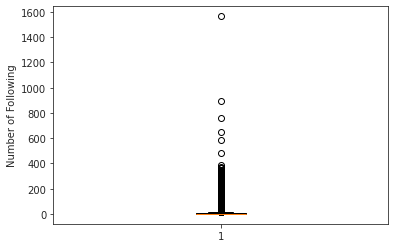

In [26]:
plt.boxplot(outdegree_dist)
plt.ylabel('Number of Following')

Percentile Analysis

In [28]:
for i in range(1,11):
    print(f"{90+i} percentile value is {np.percentile(outdegree_dist, 90+i)}")

91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


Closer inspection of percentile values between 99 and 100

In [29]:
for i in range(1,11):
    print(f"{99 + (i/10)} percentile value is {np.percentile(outdegree_dist, 99 + (i/10))}")

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


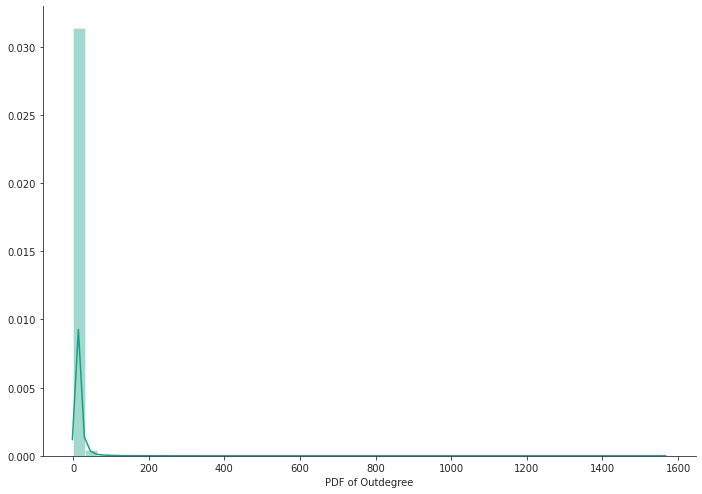

In [30]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [38]:
print(f"Number of people that do not follow anyone: {np.sum(np.array(outdegree_dist)==0)} or {(np.sum(np.array(outdegree_dist)==0)/len(outdegree_dist)*100)} %")

Number of people that do not follow anyone: 274512 or 14.741115442858524 %


In [42]:
print(f"Number of people without any followers: {np.sum(np.array(indegree_dist)==0)} or {(np.sum(np.array(indegree_dist)==0)/len(outdegree_dist)*100)} %")

Number of people without any followers: 188043 or 10.097786512871734 %


In [54]:
count = 0
for i in g.nodes():
    if len(list(g.predecessors(i))) == 0:
        if len(list(g.successors(i))) == 0:
            count += 1
print(f"Number of people that do not follow anyone and don't have any followers: {count} or {(count/len(indegree_dist))*100} %")

Number of people that do not follow anyone and don't have any followers: 0 or 0.0 %


Analysing both Followers and Following combined

In [56]:
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

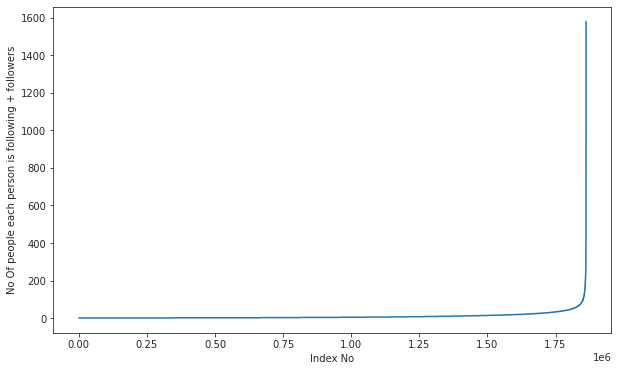

In [57]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

Zooming in a bit.

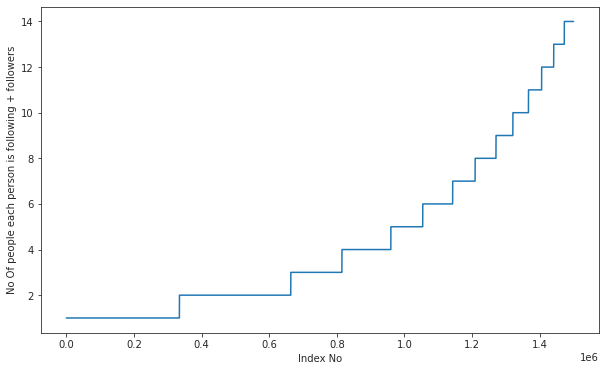

In [58]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [59]:
for i in range(0,11):
    print(f"{90+i} percentile value is {np.percentile(in_out_degree_sort,90+i)}")

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


Closer inspection of percentile values between 99 and 100.

In [62]:
for i in range(1,11):
    print(f"{99+i/10} percentile value is {np.percentile(in_out_degree_sort,99+i/10)}")

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [67]:
print(f"Minimum number of followers and following the minimum number of people is {in_out_degree.min()}")
print(f"Number of people having minimum number of followers and following the minimum number of people is {np.sum(in_out_degree==in_out_degree.min())}")

Minimum number of followers and following the minimum number of people is 1
Number of people having minimum number of followers and following the minimum number of people is 334291


In [68]:
print(f"Maximum number of followers and following the maximum number of people is {in_out_degree.max()}")
print(f"Number of people having maximum number of followers and following the minimum number of people is {np.sum(in_out_degree==in_out_degree.max())}")

Maximum number of followers and following the maximum number of people is 1579
Number of people having maximum number of followers and following the minimum number of people is 1


In [69]:
print(f"No of persons having followers + following less than 10 are {np.sum(in_out_degree<10)}")

No of persons having followers + following less than 10 are 1320326


Weakly Connected Components can be seen as communites/group of people that are familiar with each other

In [70]:
print(f"Number of weakly connected components {len(list(nx.weakly_connected_components(g)))}")
count = 0
for i in list(nx.weakly_connected_components(g)):
    if len(i) == 2:
        count += 1
print(f"Weakly connected components with 2 nodes {count}")

Number of weakly connected components 45558
Weakly connected components with 2 nodes 32195


## Posing the Problem as  Binary Classification

The original dataset consists of only samples that have connections. We can generate the edges that do not have a connection and label them as 0. Choosing vertices that have shortest path greater than 2 will help as there is less chance that they maybe connected. 

In [72]:
%%time

if not os.path.isfile('./data/after_eda/missing_edges_final.p'):
    # Getting all sets of edges
    r = csv.reader(open('./data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
    missing_edges = set([])
    while(len(missing_edges)<9437519):
        a = random.randint(1, 1862220)
        b = random.randint(1, 1862220)
        tmp = edges.get((a,b), -1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g, source=a, target=b) > 2:
                    missing_edges.add((a,b))
                else:
                    continue
            except:
                missing_edges.add((a,b))
        else:
            continue
    pickle.dump(missing_edges, open('./data/after_eda/missing_edges_final.p', 'wb'))
else:
    missing_edges = pickle.load(open('./data/after_eda/missing_edges_final.p', 'rb'))

CPU times: user 2.3 s, sys: 862 ms, total: 3.16 s
Wall time: 4 s


In [73]:
len(missing_edges)

9437519

## Training and Test Data Split

We do not need every single non existant edge. We can randomly split from them. In production this is not a good choice because, the real time data is not going to be one snapshot of the data but a temporal one. That allows more inferences to be made and split based on the time stamps. Since this is only one snapshot at one time, we need to do a random split.

In [74]:
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    df_pos = pd.read_csv('./data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    print(f"Number of nodes in the graph with edges {df_pos.shape[0]}")
    print(f"Number of nodes in the graph without edges {df_neg.shape[0]}")

    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(df_pos, np.ones(len(df_pos)), test_size=0.2, random_state=42)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(df_neg, np.ones(len(df_neg)), test_size=0.2, random_state=42)

    print('**'*40)

    print(f"Number of nodes in the train data graph with edges {X_train_pos.shape[0]}")
    print(f"Number of nodes in the train data graph without edges {X_train_neg.shape[0]}")

    print('**'*40)

    print(f"Number of nodes in the test data graph with edges {X_test_pos.shape[0]}")
    print(f"Number of nodes in the test data graph without edges {X_test_neg.shape[0]}")

    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    del missing_edges

In [75]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print(f"Number of Common Users in Train and Test Graphs: {trY_teY}")
    print(f"Number of Users present in Train Graph but not in Test Graph: {trY_teN}")
    print(f"Number of Users present in Test Graph but not in Train Graph: {teY_trN}")
    print(f"Percentage of Users not in Train but exist in Test in total Test Data are: {teY_trN/len(test_nodes_pos)*100}")  

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
Number of Common Users in Train and Test Graphs: 1063125
Number of Users present in Train Graph but not in Test Graph: 717597
Number of Users present in Test Graph but not in Train Graph: 81498
Percentage of Users not in Train but exist in Test in total Test Data are: 7.1200735962845405


# Featurization

## Reading Data

In [2]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("File not found.")

DiGraph with 1780722 nodes and 7550015 edges


## Jaccard Distance

Jaccard Distance of (X, Y) = |(Intersection of X and Y)|/|(Union of X and Y)|.
Can be calculated for followers (users that follow X) and followees (users that X follows)/

In [2]:
def jaccard_for_followees(a, b):
    try:
        # As long as there are more than 1 followee for a and b. 
        if (len(set(train_graph.successors(a))) != 0) and (len(set(train_graph.successors(b))) != 0):
            sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/(len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
        else:
            return 0
    except:
        return 0
    return sim

In [32]:
# Testing the function
print(jaccard_for_followees(273084, 1505602))

0.0


In [3]:
def jaccard_for_followers(a, b):
    try:
        if len(set(train_graph.predecessors(a))) == 0 | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/(len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [35]:
# Testing the function
print(jaccard_for_followers(273084,470294))

0


## Cosine Distance
Cosine Distance(X, Y) = |(Intersection of X and Y)|(Sqrt(|X|*|Y|))

In [4]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/(math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [37]:
# Testing the Function
print(cosine_for_followees(273084,1505602))

0.0


In [5]:
def cosine_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/(math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [40]:
# Testing the Function
print(cosine_for_followers(669354,1635354))

0


## PageRank

## Shortest Path between two nodes
Ignoring any direct edge and finding the shortest path between two nodes.

In [6]:
def compute_shortest_path(a, b):
    # Default Value is -1
    p = -1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a, b)
            p = nx.shortest_path_length(train_graph, source=a, target=b)
            train_graph.add_edge(a,b)
        else:
            p = nx.shortest_path_length(train_graph, source=a, target=b)
        return p
    except:
        return -1

In [42]:
# Testing the Function
compute_shortest_path(123,23145)

10

## Checking if they belong to the same Weakly Connected Component (Community/Group)

In [43]:
wcc = list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a, b):
    index = []
    if train_graph.has_edge(b, a):
        return 1
    if train_graph.has_edge(a, b):
        for i in wcc:
            if a in i:
                index = i
                break
        if b in index:
            train_graph.remove_edge(a,b)
            if compute_shortest_path(a,b)==1:
                train_graph.add_edge(a,b)
                return 0
            else:
                train_graph.add_edge(a,b)
                return 1
        else:
            return 0
    else:
        for i in wcc:
            if a in i:
                index = i
                break
        if b in index:
            return 1
        else:
            return 0

In [44]:
# Testing the Function
belongs_to_same_wcc(861, 1659750)

1

## Adamic/Adar Index
Inverted Sum of Degrees of Common Neighbours for given two vectors. Common Elements of X and Y with many neighbours less significant than common elements of X & Y with less neighbours. 

In [7]:
def calc_adar_index(a, b):
    sum = 0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum = sum + (1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [46]:
calc_adar_index(983,23421)

0

## Is User following back?

In [8]:
def follows_back(a,b):
    if train_graph.has_edge(b, a):
        return 1
    else:
        return 0

In [48]:
follows_back(12231,42021)

0

## Katz Centrality
Used to measure relative degree of influence of User within a network. It is a generalization of Eigen Vector Centrality. 

In [49]:
if not os.path.isfile('./data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph, alpha = 0.005, beta=1)
    pickle.dump(katz, open('./data/fea_sample/katz.p', 'wb'))
else:
    katz = pickle.load(open('./data/fea_sample/katz.p', 'rb'))

In [50]:
print(f"Minimum: {katz[min(katz, key=katz.get)]}")
print(f"Maximum: {katz[max(katz, key=katz.get)]}")
print(f"Mean: {float(sum(katz.values())/len(katz))}")

Minimum: 0.0007313532484065916
Maximum: 0.003394554981699122
Mean: 0.0007483800935562018


## HITS Score
HITS is an iterative algorithm that gives a Hub Score and an Authority Score to each node based on the number of incoming links and the number of outgoing links. 

In [51]:
if not os.path.isfile('./data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter = 100, tol = 1e-08, nstart=None, normalized=True)
    pickle.dump(hits, open('./data/fea_sample/hits.p', 'wb'))
else:
    hits = pickle.load(open('./data/fea_sample/hits.p','rb'))

In [53]:
print(f"Minimum: {hits[0][min(hits[0], key=hits[0].get)]}")
print(f"Maximum: {hits[0][max(hits[0], key=hits[0].get)]}")
print(f"Mean: {float(sum(hits[0].values())/len(hits[0]))}")

Minimum: 0.0
Maximum: 0.004868653378780953
Mean: 5.615699699344123e-07


# Adding Features to Data

## Reading Sample of Data from Train and Test
Since Random Split is being used, creating a list of random numbers of preferred Sample Size.

In [9]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    n_train = 15100028
    s = 100000
    skip_train = sorted(random.sample(range(1, n_train+1), n_train-s))

In [10]:
if os.path.isfile('data/after_eda/test_after_eda.csv'):
    n_test = 3775006
    s = 50000
    skip_test = sorted(random.sample(range(1, n_test+1), n_test-s))

In [11]:
df_final_train = pd.read_csv('./data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print(f"Train Matrix Size: {df_final_train.shape}")
df_final_train.head(2)

Train Matrix Size: (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,117851,598891,1


In [12]:
df_final_test = pd.read_csv('./data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print(f"Test Matrix Size: {df_final_test.shape}")
df_final_test.head(5)

Test Matrix Size: (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,104114,57653,1
2,788249,1709436,1
3,1145863,866269,1
4,557644,941303,1


In [20]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7


In [25]:
train_graph = nx.from_pandas_edgelist(df_final_train,'source_node', 'destination_node', create_using=nx.DiGraph())
test_graph = nx.from_pandas_edgelist(df_final_test,'source_node', 'destination_node', create_using=nx.DiGraph())
print(nx.info(train_graph))
print(nx.info(test_graph))

# finding the unique nodes in the both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print(f"Number of Common Users in Train and Test Graphs: {trY_teY}")
print(f"Number of Users present in Train Graph but not in Test Graph: {trY_teN}")
print(f"Number of Users present in Test Graph but not in Train Graph: {teY_trN}")
print(f"Percentage of Users not in Train but exist in Test in total Test Data are: {teY_trN/len(test_nodes_pos)*100}")  

DiGraph with 95694 nodes and 50002 edges
DiGraph with 95796 nodes and 50002 edges
Number of Common Users in Train and Test Graphs: 8988
Number of Users present in Train Graph but not in Test Graph: 86706
Number of Users present in Test Graph but not in Train Graph: 86808
Percentage of Users not in Train but exist in Test in total Test Data are: 90.61756231992986


## Adding Features

In [13]:
def compute_features_stage1(df_final):
    # Calculating Number of Followers and Followees, Intersection of Followers and Followees for Source and Destination
    num_followers_s = []
    num_followees_s = []
    num_followers_d = []
    num_followees_d = []
    inter_followers = []
    inter_followees = []
    for i, row in df_final.iterrows():
        try:
            s1 = set(train_graph.predecessors(row['source_node']))    
            s2 = set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1 = set(train_graph.predecessors(row['destination_node']))
            d2 = set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))
        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))
        inter_followers.append(len(s1.intersection(d1)))
        inter_followers.append(len(s2.intersection(d2)))
    return num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

In [29]:
if not os.path.isfile('./data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followees_s'], \
    df_final_train['num_followers_d'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followees_s'], \
    df_final_test['num_followers_d'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

    hdf = pd.HDFStore('storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = pd.read_hdf('./data/fea_sample/storage_sample_stage1.h5', 'train_df', mode='r')
    df_final_train = pd.read_hdf('./data/fea_sample/storage_sample_stage1.h5', 'test_df', mode='r')    

In [30]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees
0,848424,784690,1,0,0.0,0.029161,0.000000,14,6,9,1,0
1,483294,1255532,1,0,0.0,0.000000,0.000000,17,1,19,0,0
2,626190,1729265,1,0,0.0,0.000000,0.000000,10,16,9,0,0
3,947219,425228,1,0,0.0,0.000000,0.000000,37,10,34,0,0
4,991374,975044,1,0,0.2,0.042767,0.347833,27,15,27,4,7


In [ ]:
a = df_final_train['num_followers_s'].values
b = df_final_train['num_followers_d'].values

In [ ]:
for x, y in zip(a, b):
    if x == 0:
        if y != 0:
            print('i')

In [ ]:
if not os.path.isfile('./data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('./data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('./data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

In [ ]:
df_final_train.head()

## Adding Weight Features

In [ ]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

## SVD Features

In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

# Modeling

## Reading Data

In [2]:
df_final_train = pd.read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df', mode = 'r')
df_final_test = pd.read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df', mode = 'r')

In [3]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [4]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [6]:
train_graph = nx.from_pandas_edgelist(df_final_train, source='source_node', target='destination_node', create_using=nx.DiGraph())
test_graph = nx.from_pandas_edgelist(df_final_test, source='source_node', target='destination_node', create_using=nx.DiGraph())

In [43]:
# df_final_train[['source_node', 'destination_node']].to_csv('train_source_destination.csv', header=False, index=False)
# df_final_test[['source_node', 'destination_node']].to_csv('test_source_destination.csv', header=False, index=False)

In [44]:
# train_graph = nx.read_edgelist('train_source_destination.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# test_graph = nx.read_edgelist('test_source_destination.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

In [10]:
num_followers_d = []
for i, row in df_final_train.iterrows():
    d1 = set(train_graph.predecessors(row['destination_node']))
    num_followers_d.append(len(d1))

In [11]:
num_followers_d_test = []
for i, row in df_final_test.iterrows():
    d1 = set(test_graph.predecessors(row['destination_node']))
    num_followers_d_test.append(len(d1))

In [12]:
df_final_train['num_followers_d'] = num_followers_d
df_final_test['num_followers_d'] = num_followers_d_test

In [13]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [14]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,num_followers_d
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,1
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,1
3,0,0.000000,0.000000,0.000000,11,5,7,0,0,0.000000,...,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13,1
4,0,0.000000,0.000000,0.000000,1,11,3,0,0,0.000000,...,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1


Estimators =  10 Train Score 0.9187265135699374 test Score 0.9140857466158167
Estimators =  50 Train Score 0.9219460680266418 test Score 0.9170516589668206
Estimators =  100 Train Score 0.9236588577041233 test Score 0.9183099773432912
Estimators =  250 Train Score 0.9228983931502409 test Score 0.9181428931240031
Estimators =  450 Train Score 0.9228148999529805 test Score 0.9177260331445354


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

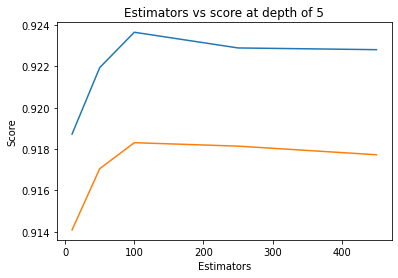

In [15]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9158702966005491 test Score 0.9046865236409081
depth =  9 Train Score 0.9558784514601742 test Score 0.9248170885543688
depth =  11 Train Score 0.9620271162341949 test Score 0.9256556394456246
depth =  15 Train Score 0.9633952039294087 test Score 0.9264003702067689
depth =  20 Train Score 0.9637283632639402 test Score 0.92639545884579
depth =  35 Train Score 0.9637623099625756 test Score 0.9264313197788104
depth =  50 Train Score 0.9637623099625756 test Score 0.9264313197788104
depth =  70 Train Score 0.9637623099625756 test Score 0.9264313197788104
depth =  130 Train Score 0.9637623099625756 test Score 0.9264313197788104


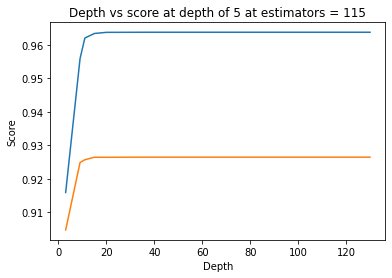

In [16]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [17]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25, return_train_score=True)

rf_random.fit(df_final_train,y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88fa854b10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88f9f421d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88fa217290>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88fa854750>},
                   random_state=25, return_train_score=True, scoring='f1')

In [18]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96248461 0.96224903 0.96064656 0.96219031 0.9635387 ]
mean train scores [0.96319445 0.96285957 0.96114321 0.96264677 0.96434092]


In [19]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [20]:
clf = RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)

In [21]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [22]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.965275242383676
Test f1 score 0.9266506754197702


In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


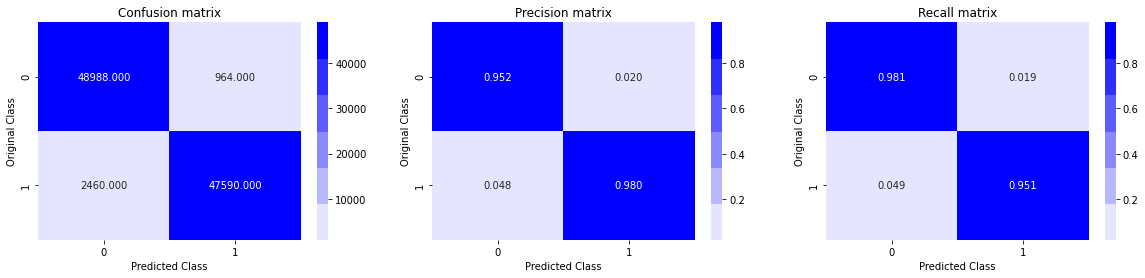

Test confusion_matrix


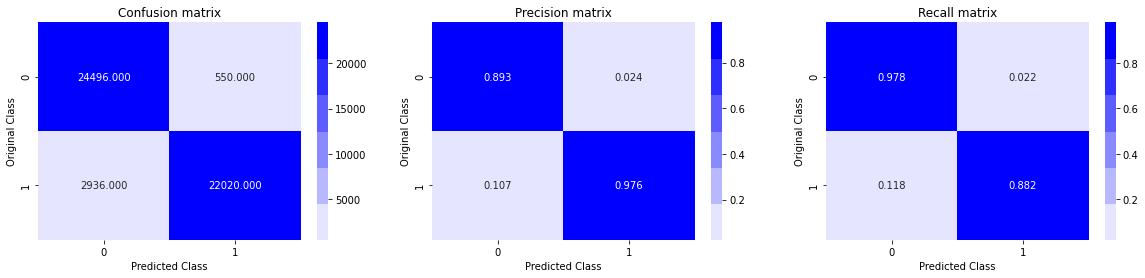

In [24]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

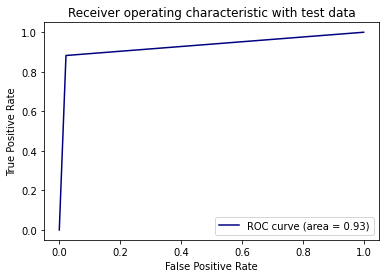

In [25]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

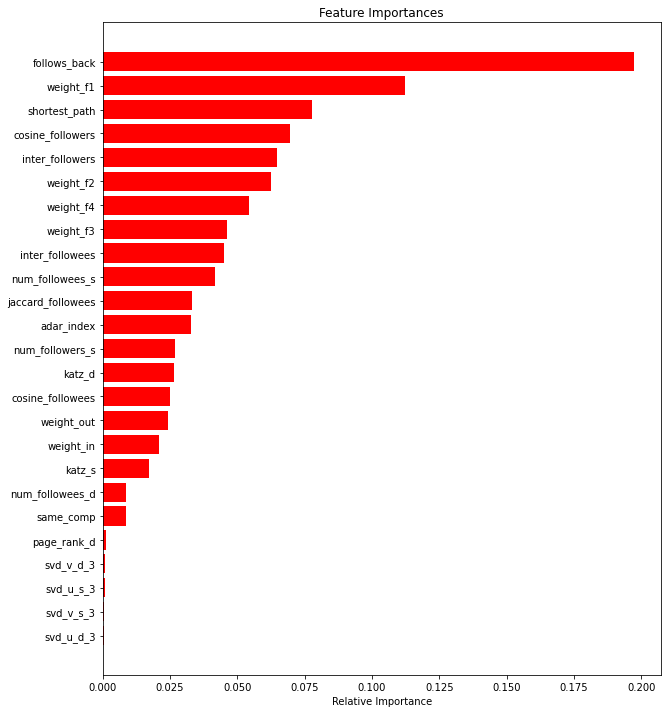

In [28]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()